YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Data Head:
Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2020-01-02  72.538513  72.598892  71.292304  71.545890  135480400
2020-01-03  71.833282  72.594048  71.608677  71.765659  146322800
2020-01-06  72.405693  72.444336  70.703027  70.954203  118387200
2020-01-07  72.065163  72.671356  71.845385  72.415353  108872000
2020-01-08  73.224396  73.526287  71.768071  71.768071  132079200


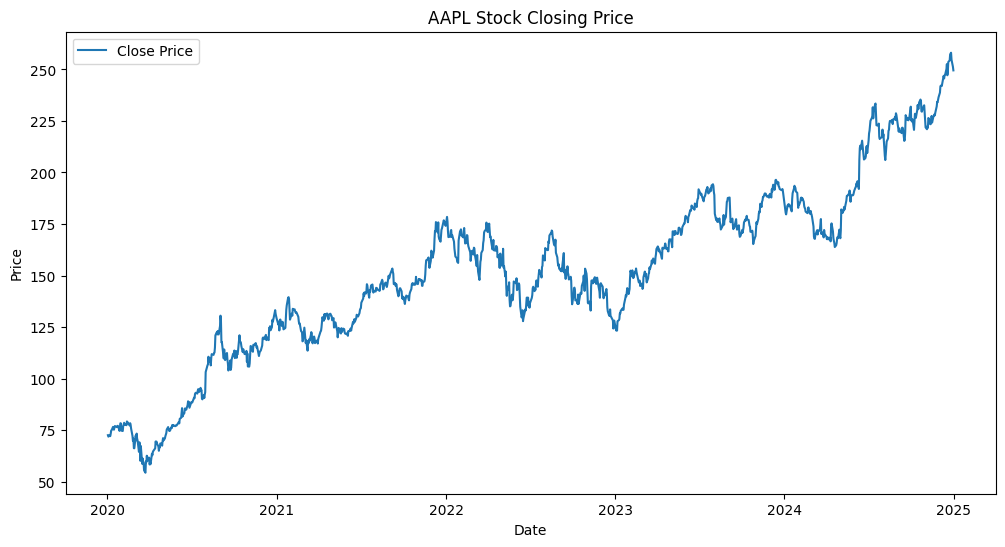

Mean Squared Error: 8.61


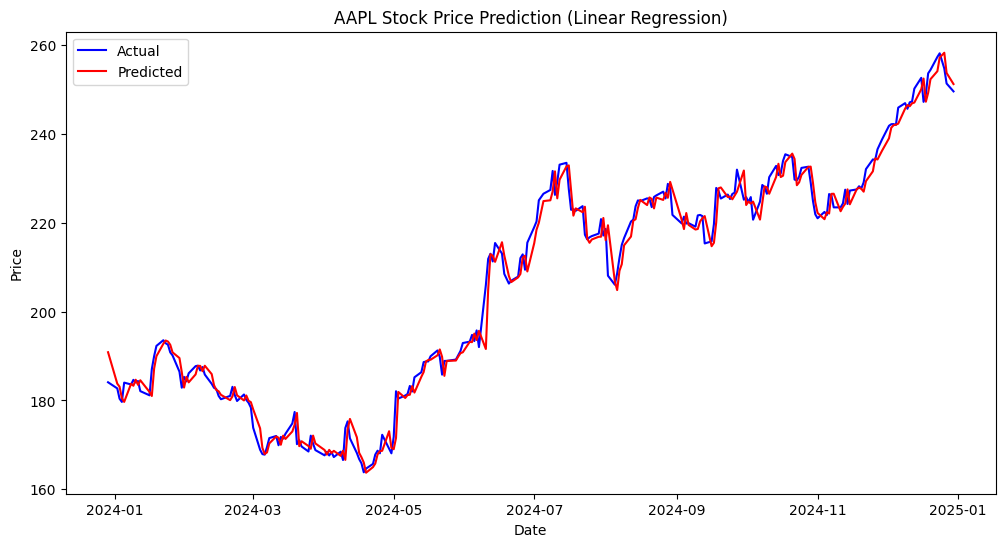

                Actual   Predicted
Date                              
2024-12-16  252.583344  250.012261
2024-12-17  247.172562  252.418521
2024-12-18  248.906403  247.206541
2024-12-19  253.589783  249.210360
2024-12-20  254.367020  252.273965
2024-12-23  257.286682  254.072098
2024-12-24  258.103729  257.141327
2024-12-26  254.685867  258.234125
2024-12-27  251.307877  253.688891
2024-12-30  249.534180  251.184269


In [1]:
# Stock Price Prediction - Apple (AAPL)
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Step 2: Download stock data
ticker = "AAPL"
data = yf.download(ticker, start="2020-01-01", end="2025-01-01")
print("Data Head:")
print(data.head())

# Step 3: Visualize closing price
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price')
plt.title(f'{ticker} Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 4: Prepare data for ML
data['Target'] = data['Close'].shift(-1)  # Next day close
data.dropna(inplace=True)

X = data[['Open','High','Low','Close','Volume']]  # Features
y = data['Target']  # Labels

# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Step 5: Train Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
predictions = model.predict(X_test)

# Step 6: Evaluate model
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse:.2f}")

# Step 7: Plot predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(y_test.index, predictions, label='Predicted', color='red')
plt.title(f'{ticker} Stock Price Prediction (Linear Regression)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Optional: Look at the last few predictions vs actual
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': predictions})
print(result_df.tail(10))


#Prediction for future using LSTM 

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2025-01-01")
close_prices = data['Close'].values.reshape(-1,1)

# Step 2: Scale data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(close_prices)

# Step 3: Prepare sequences
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)  # LSTM expects 3D input

# Step 4: Split into train/test
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Step 5: Build LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step,1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 6: Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

# Step 7: Predict on test set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

# Step 8: Plot test predictions
plt.figure(figsize=(12,6))
plt.plot(y_test_scaled, label='Actual Price', color='blue')
plt.plot(predictions, label='Predicted Price', color='red')
plt.title(f'{ticker} Stock Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Step 9: Predict future n days
future_days = 30
temp_input = scaled_data[-time_step:].tolist()
lst_output = []

for i in range(future_days):
    x_input = np.array(temp_input[-time_step:])
    x_input = x_input.reshape(1,time_step,1)
    yhat = model.predict(x_input, verbose=0)
    lst_output.append(yhat[0,0])
    temp_input.append(yhat[0,0])

# Convert future predictions back to original scale
future_predictions = scaler.inverse_transform(np.array(lst_output).reshape(-1,1))

# Plot future predictions
plt.figure(figsize=(12,6))
plt.plot(range(1,future_days+1), future_predictions, label='Future Predictions', color='green')
plt.title(f'{ticker} Stock Price - Next {future_days} Days Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.show()